In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [ ]:
def resize_image(image, width=None, height=None):
    if width is not None and height is not None:
        return cv2.resize(image, (width, height))
    elif width is not None:
        h, w = image.shape[:2]
        aspect_ratio = width / w
        return cv2.resize(image, (width, int(h * aspect_ratio)))
    elif height is not None:
        h, w = image.shape[:2]
        aspect_ratio = height / h
        return cv2.resize(image, (int(w * aspect_ratio), height))

In [ ]:
def atm_conversion(image, omega=0.8, radius=50):
    radius = radius if radius % 2 != 0 else radius + 1  # Ensure radius is odd
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.medianBlur(gray, radius)
    atm_value = np.percentile(gray_blur, omega * 100)
    return atm_value

In [ ]:
def dark_channel(image, radius=50):
    min_channel = np.amin(image, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (radius, radius)) #kernel is applied on the minimum channel
    dark_channel = cv2.erode(min_channel, kernel) #each pixel is replaced with the minimum value
    return dark_channel

In [ ]:
def transmission_map(image, atm_value, radius=50, omega=0.8):
    normalized_image = image.astype(np.float32) / atm_value
    dark_channel_image = dark_channel(normalized_image, radius)
    transmission = 1 - omega * dark_channel_image
    return transmission

In [ ]:
def guided_filter(I, p, r, eps):
    mean_I = cv2.boxFilter(I, cv2.CV_32F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_32F, (r, r))
    mean_Ip = cv2.boxFilter(I * p, cv2.CV_32F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(I * I, cv2.CV_32F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_32F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_32F, (r, r))

    q = mean_a * I + mean_b
    return q

In [ ]:
def refine_transmission(image, transmission, radius=50, eps=0.001):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.0
    transmission_refined = guided_filter(gray.astype(np.float32), transmission.astype(np.float32), radius, eps)
    return transmission_refined

In [ ]:
def haze_removal(image, transmission, atm_value, t0=0.1):
    transmission = np.maximum(transmission, t0)
    scene_radiance = np.zeros_like(image, dtype=np.float32)
    for i in range(3):
        scene_radiance[:, :, i] = (image[:, :, i].astype(np.float32) - atm_value) / transmission + atm_value
    scene_radiance = np.clip(scene_radiance, 0, 255).astype(np.uint8)
    return scene_radiance

In [ ]:
def psnr(original, processed):
    mse = np.mean((original.astype(np.float32) - processed.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

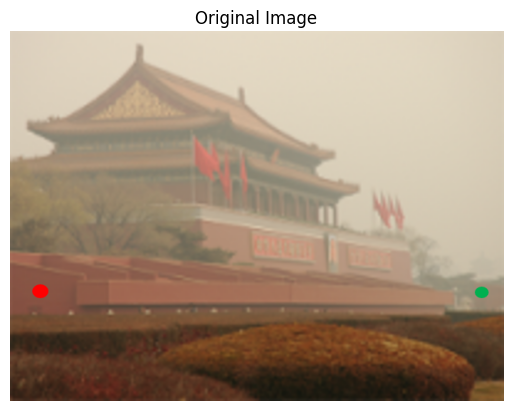

In [ ]:
# Step 1: Input image
input_image = cv2.imread("/content/Hazed-input-image-and-dehazed-output-image - Copy.png")
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

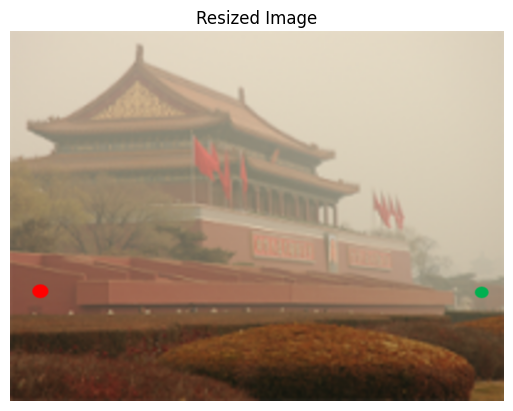

In [ ]:
# Step 2: Image resize and datatype conversion
resized_image = resize_image(input_image, width=800, height=None)
resized_image = resized_image.astype(np.uint8)

# Display resized image
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title("Resized Image")
plt.axis('off')
plt.show()

In [ ]:
# Step 3: ATM conversion
atm_value = atm_conversion(resized_image)
print("ATM Value:", atm_value)

ATM Value: 209.0


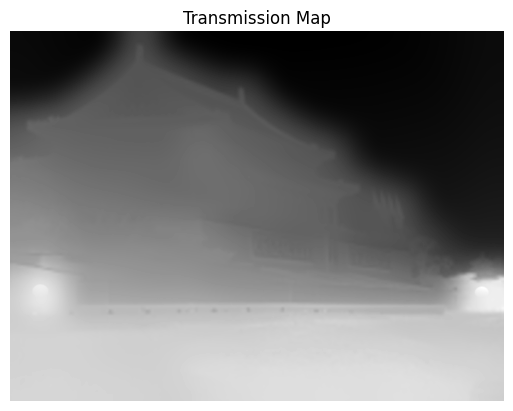

In [ ]:
# Step 4: Transmission map
transmission = transmission_map(resized_image, atm_value)
transmission = refine_transmission(resized_image, transmission)

# Display transmission map
plt.imshow(transmission, cmap='gray')
plt.title("Transmission Map")
plt.axis('off')
plt.show()

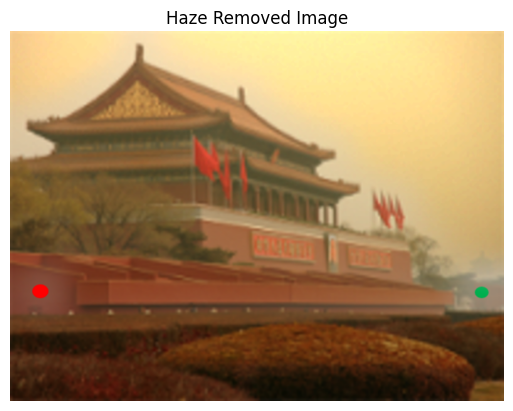

In [ ]:
# Step 5: Haze removal
haze_removed_image = haze_removal(resized_image, transmission, atm_value)

# Display haze removed image
plt.imshow(cv2.cvtColor(haze_removed_image, cv2.COLOR_BGR2RGB))
plt.title("Haze Removed Image")
plt.axis('off')
plt.show()

In [ ]:
# Step 6: Performance evaluation
psnr_value = psnr(resized_image, haze_removed_image)
mse_value = np.mean((resized_image.astype(np.float32) - haze_removed_image.astype(np.float32)) ** 2)
print("PSNR:", psnr_value)
print("MSE:", mse_value)

PSNR: 17.46942517201108
MSE: 1164.4955
